I was summarising the literature review for one of the chapters of my PhD thesis in a form of a table, when I thought about sorting it by the number of times each reference has been cited. These metadata are not static and so are usually not stored in reference managing software (e.g. [Mendeley](https://www.mendeley.com)) or BibTeX files.

I certainly could have looked up each of the publications (especially that there are only 16 of them so far). But I'm lazy! So after some googling I found that [Scopus](https://www.elsevier.com/solutions/scopus?) - Elsevier-owned largest abstract and citation database of peer-reviewed literature - has a Python API. The [package](https://github.com/scopus-api/scopus) offers everything I need and is active on GitHub, so I decided to stick with it, though there are certainly other citation databases, for instance Google Scholar (perhaps I will explore its API in another post). The downside of using Scopus API is that it's not free. Luckily, University of East Anglia provides an access to it.

The journey starts by pip-installing the `scopus` package and then obtaining a key from Elsevier Dev centre (as explained in the [README](https://github.com/scopus-api/scopus#get-a-scopus-api-key)). In addition, I installed `bibtexparser` package needed for loading my references from a BibTeX file.

Once everything is installed, let's import the packages.

In [1]:
import bibtexparser
import re
from scopus.scopus_api import ScopusAbstract
from scopus.scopus_search import ScopusSearch

# For a fancy progress bar
from tqdm import tqdm_notebook as tqdm

# Print package info
%load_ext watermark
%watermark -v -p bibtexparser,scopus

CPython 3.6.2
IPython 6.1.0

bibtexparser 0.6.2
scopus 0.4.3


## The list of references

Now we load the references.

In [2]:
with open('../_data/polarlow_climatologies.bib', 'r') as bibtex_file:
    bibs = bibtexparser.load(bibtex_file)

The resulting `bibs` variable is `BibDatabase` containing all 16 entries as plain dictionaries.

For example, the first entry is

In [3]:
print(bibs.entries[0])

{'author': 'Blechschmidt, A.-M. and Bakan, S. and Gra{\\ss}l, H.', 'doi': '10.1029/2008JD010865', 'journal': 'J. Geophys. Res.', 'keyword': 'PMC,climatology', 'link': 'http://doi.wiley.com/10.1029/2008JD010865', 'number': 'D6', 'pages': 'D06115', 'title': 'Large-scale atmospheric circulation patterns during polar low events over the Nordic seas', 'volume': '114', 'year': '2009', 'ENTRYTYPE': 'article', 'ID': 'BlechschmidtEtAl2009'}


What we are interested in now, is the DOI of the article, by which we will do the search in Scopus. Our BibTeX file contains DOIs for each of the references. If it didn't we would probably search by titles using try/except, e.g.:

In [4]:
try:
    _query = 'DOI({})'.format(bibs.entries[0]['doi'])
except KeyError:
    # if there is no DOI
    _query = 'TITLE ({})'.format(re.sub(r'([^\s\w\-]|_)+', '', bibs.entries[0]['title']))

## Scopus mining

The first instance that we need is `scopus.scopus_search.ScopusSearch`, which takes a query and returns a list of EIDs - internal Scopus identifiers. To construct a query using DOI is pretty straightforward, as I found [here](https://dev.elsevier.com/tecdoc_cited_by_in_scopus.html).

In [5]:
QUERY_FMT = 'DOI({})'  # query format

`ScopusSearch` returns a result containing the list of article identificators (which is of length 1 when using DOI). Then the EID can be passed to `scopus.scopus_api.ScopusAbstract` to retrieve the full metadata.

For example, using the just created variable `_query`, we can send a request to Scopus:

In [6]:
sc_search = ScopusSearch(_query)

There is only one identificator in the list:

In [7]:
print(sc_search.EIDS)

['2-s2.0-66449109996']


In [8]:
ab = ScopusAbstract(sc_search.EIDS[0])

In [9]:
print(ab)

[[https://www.scopus.com/inward/record.uri?partnerID=HzOxMe3b&scp=66449109996&origin=inward][2-s2.0-66449109996]]  A.-M. Blechschmidt, S. Bakan and H. Graßl, Large-scale atmospheric circulation patterns during polar low events over the Nordic seas, Journal of Geophysical Research Atmospheres, 114(6), (no pages found) (2009). http://dx.doi.org/10.10.29/2008JD010865, https://www.scopus.com/inward/record.uri?partnerID=HzOxMe3b&scp=66449109996&origin=inward, cited 22 times (Scopus).
  Affiliations:
   id:60028564 None
   id:60028229 None


As we can see, the metadata contain such information as the number of citations and authors' affiliations. I will use the former here and probably will write another post based on the latter.

Thus, iterating over the entries of the `BibDatabase` bibs, we can retrieve the number of citations for each of them and stored it in the same dictionary.

In [10]:
for entry in tqdm(bibs.entries):
    query = QUERY_FMT.format(entry['doi'])
        
    sc_search = ScopusSearch(query)
    try:
        ab = ScopusAbstract(sc_search.EIDS[0])
        entry['citedby_count'] = ab.citedby_count
    except IndexError:
        # if no EID found
        entry['citedby_count'] = None

A Jupyter Widget

## Playing with the results

Now each of the entries contains an additional field "citedby_count":

In [11]:
entry

{'ENTRYTYPE': 'article',
 'ID': 'ZappaEtAl2014',
 'author': 'Zappa, Giuseppe and Shaffrey, Len and Hodges, Kevin',
 'citedby_count': 22,
 'doi': '10.1175/MWR-D-14-00064.1',
 'journal': 'Mon. Weather Rev.',
 'keyword': 'PMC,climatology,reanalysis',
 'link': 'http://journals.ametsoc.org/doi/abs/10.1175/MWR-D-14-00064.1',
 'month': 'aug',
 'number': '8',
 'pages': '2596--2608',
 'title': 'Can Polar Lows be Objectively Identified and Tracked in the ECMWF Operational Analysis and the ERA-Interim Reanalysis?',
 'volume': '142',
 'year': '2014'}

Let's look at the results. I am too lazy, so we just pass the citation counts into a `pandas.DataFrame` and use it in the plotting section.

In [12]:
import pandas as pd

In [13]:
df = pd.DataFrame(data={'citation_count': [entry['citedby_count'] for entry in bibs.entries],
                        'year': [entry['year'] for entry in bibs.entries]},
                  index=[entry['ID'] for entry in bibs.entries])

In [14]:
%matplotlib inline

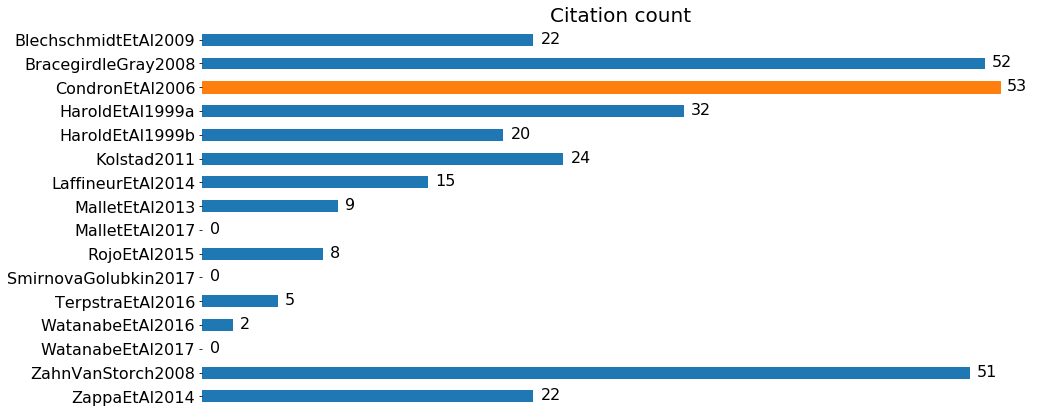

In [15]:
ax = df[['citation_count']].plot.barh(legend=None, figsize=(15, 7))
ax.invert_yaxis()

for spine in ax.spines.values():
    spine.set_linewidth(0)
ax.xaxis.set_ticks([])

for p in ax.patches:
    ax.annotate('{:d}'.format(round(p.get_width())),
                (p.get_width() + 0.5, p.get_y() + 0.4),
                size=16)
    if p.get_width() == df['citation_count'].values.max():
        p.set_color('C1')

ax.set_title('Citation count', fontsize=20)
ax.tick_params(labelsize=16)

Apparently, the winner among these is the publication by [Condron et al. (2006)](http://journals.ametsoc.org/doi/abs/10.1175/MWR3136.1) with 53 citations, at least according to Scopus records.

## Export to LaTeX

Finally, I wanted to include the citation information into my LaTeX table. Fortunately, `pandas` library allows me to do just that, and sort by year of the publication.

In [16]:
print(df.sort_values('year').to_latex())

\begin{tabular}{lrl}
\toprule
{} &  citation\_count &  year \\
\midrule
HaroldEtAl1999a      &              32 &  1999 \\
HaroldEtAl1999b      &              20 &  1999 \\
CondronEtAl2006      &              53 &  2006 \\
BracegirdleGray2008  &              52 &  2008 \\
ZahnVanStorch2008    &              51 &  2008 \\
BlechschmidtEtAl2009 &              22 &  2009 \\
Kolstad2011          &              24 &  2011 \\
MalletEtAl2013       &               9 &  2013 \\
LaffineurEtAl2014    &              15 &  2014 \\
ZappaEtAl2014        &              22 &  2014 \\
RojoEtAl2015         &               8 &  2015 \\
TerpstraEtAl2016     &               5 &  2016 \\
WatanabeEtAl2016     &               2 &  2016 \\
MalletEtAl2017       &               0 &  2017 \\
SmirnovaGolubkin2017 &               0 &  2017 \\
WatanabeEtAl2017     &               0 &  2017 \\
\bottomrule
\end{tabular}



Some rights reserved. This work permits non-commercial use, distribution, and reproduction in any medium, provided the original author and source are credited.